In [ ]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv # librairie OpenCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# ouvrir les images en RGB et en niveaux de gris dans [[0;255]]
Ig, Id, gt = data.stereo_motorcycle()
Iggray = (rgb2gray(Ig)*255).astype('uint8')
Idgray = (rgb2gray(Id)*255).astype('uint8')

In [ ]:
# mean intensities of the images
melted = ((Iggray/2 + Idgray/2)).astype('uint8')
plt.imshow(melted, cmap='gray')
plt.axis("off")
# la disparité max semble être de 60 sur la roue avant (à l'oeil)
maxdisp = 60

## depth estimation with stereo matching

### StereoBM

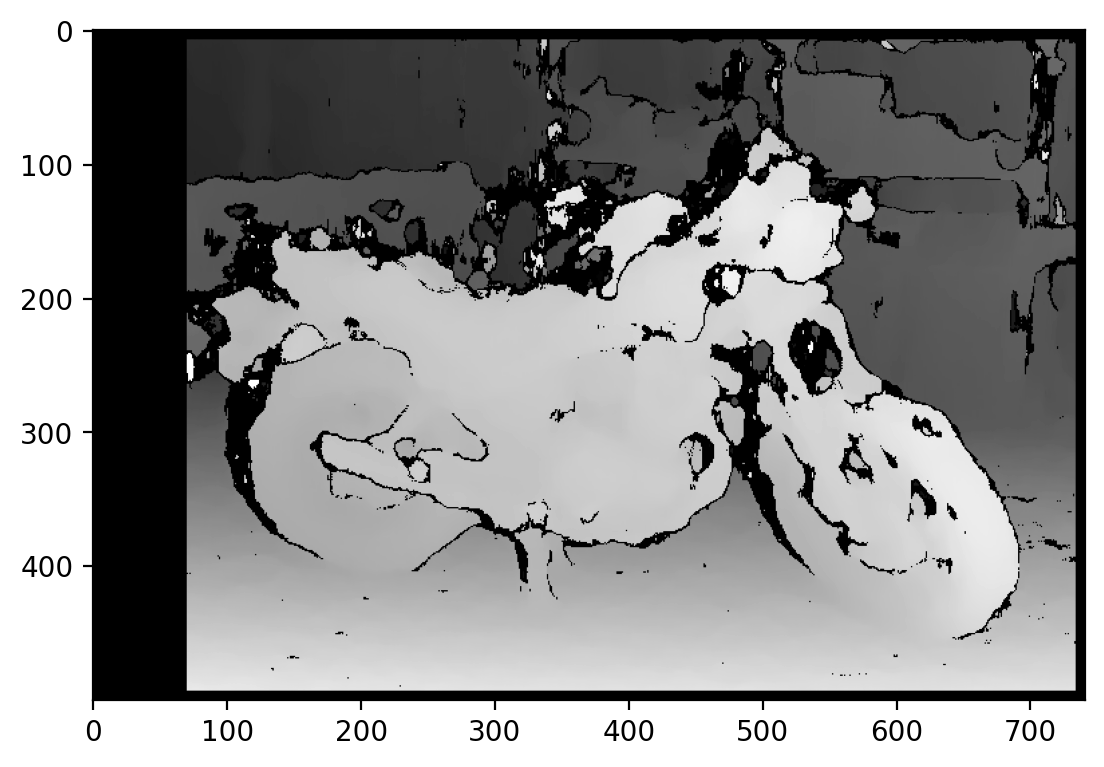

In [ ]:
# attention avec ces implementations,
# numDisparities doit etre divisible par 16,
# les algos proposent une precision a 1/16 pixel ;
# en cherchant les disparites avec un pas de 1/16 # les disparites reelles s'en retrouvent *16
numdisp = maxdisp if maxdisp%16==0 else ((maxdisp//16)+1)*16
# Block Matching
# attention, cette implementation ne fonctionne que
# pour des images en niveaux de gris
stereoBM = cv.StereoBM.create(numDisparities=numdisp , blockSize =15) # blockSize impair
dispBM = stereoBM.compute(Iggray ,Idgray).astype(np.float32) / 16.0
# affichage de la carte de disparite
plt.imshow(dispBM, cmap='gray')

### StereoSGBM

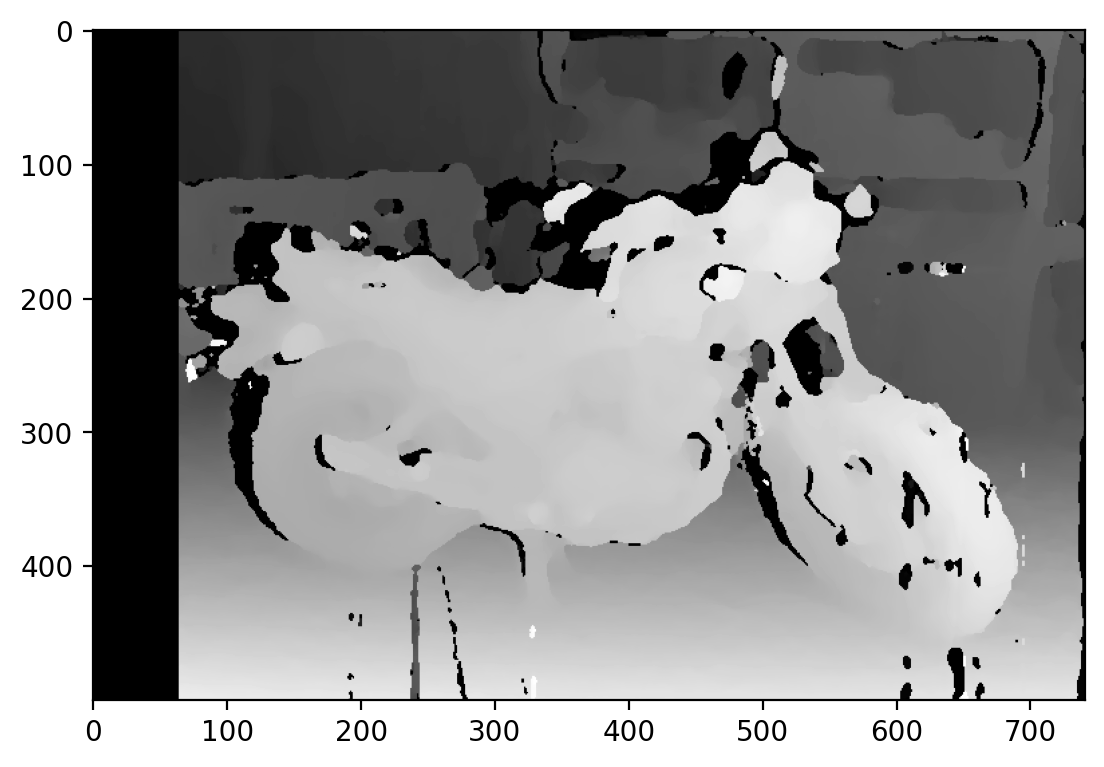

In [6]:
# Semi Global Block Matching
# peut traiter des images RGB ou en niveaux de gris
stereoSGBM = cv.StereoSGBM.create(numDisparities=numdisp , blockSize =15) # impair
dispSGBM = stereoSGBM.compute(Ig,Id).astype(np.float32) / 16.0
plt.imshow(dispSGBM, cmap='gray')

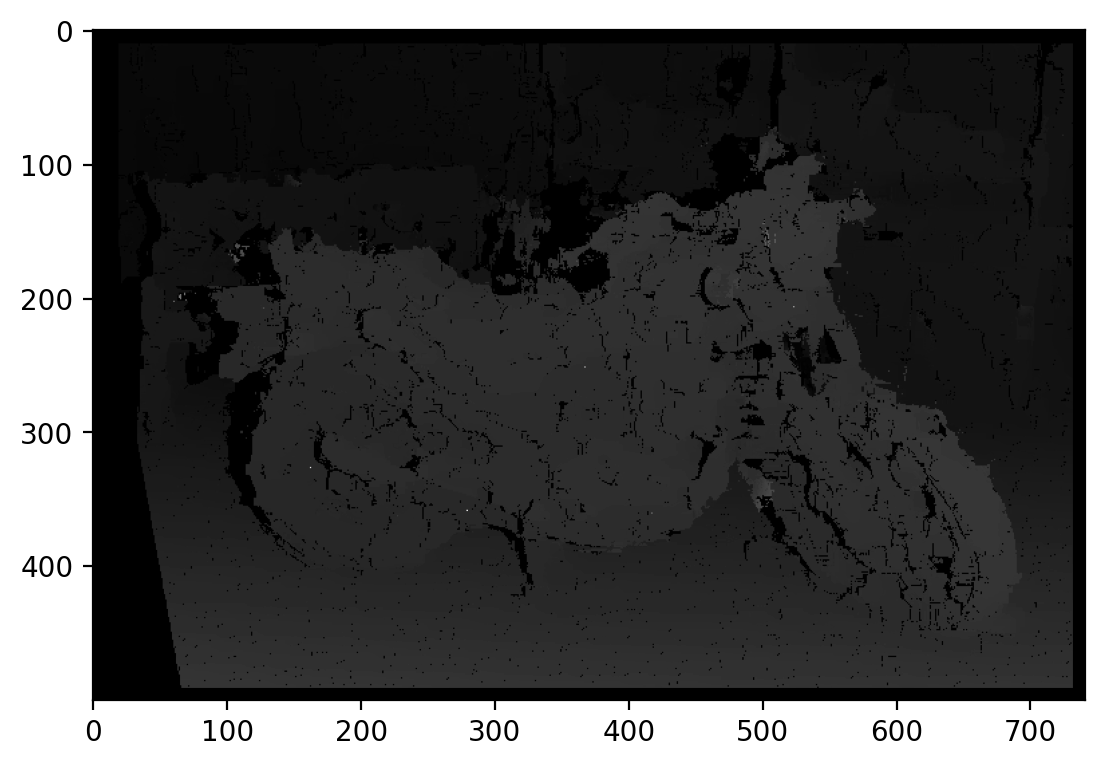

In [49]:
# Stereo Quasi Dense ,
# eparse puis densification par propagation
# !! necessite OpenCV >= 4.5
# travaille en niveau de gris, meme avec des images RGB # donne directement les disparites relles
stereoQD = cv.stereo_QuasiDenseStereo.create(monoImgSize=Iggray.shape[::-1])
stereoQD.process(Iggray ,Idgray)
dispQD = stereoQD.getDisparity()
dispQD = np.nan_to_num(dispQD)
plt.imshow(dispQD, cmap='gray')

In [8]:
# clean all disparity maps with a mask >0 ( except for QD which is non-nan)
dispBM_mask = (dispBM>0)
dispSGBM_mask = (dispSGBM>0)
dispQD_mask = (dispQD>0)

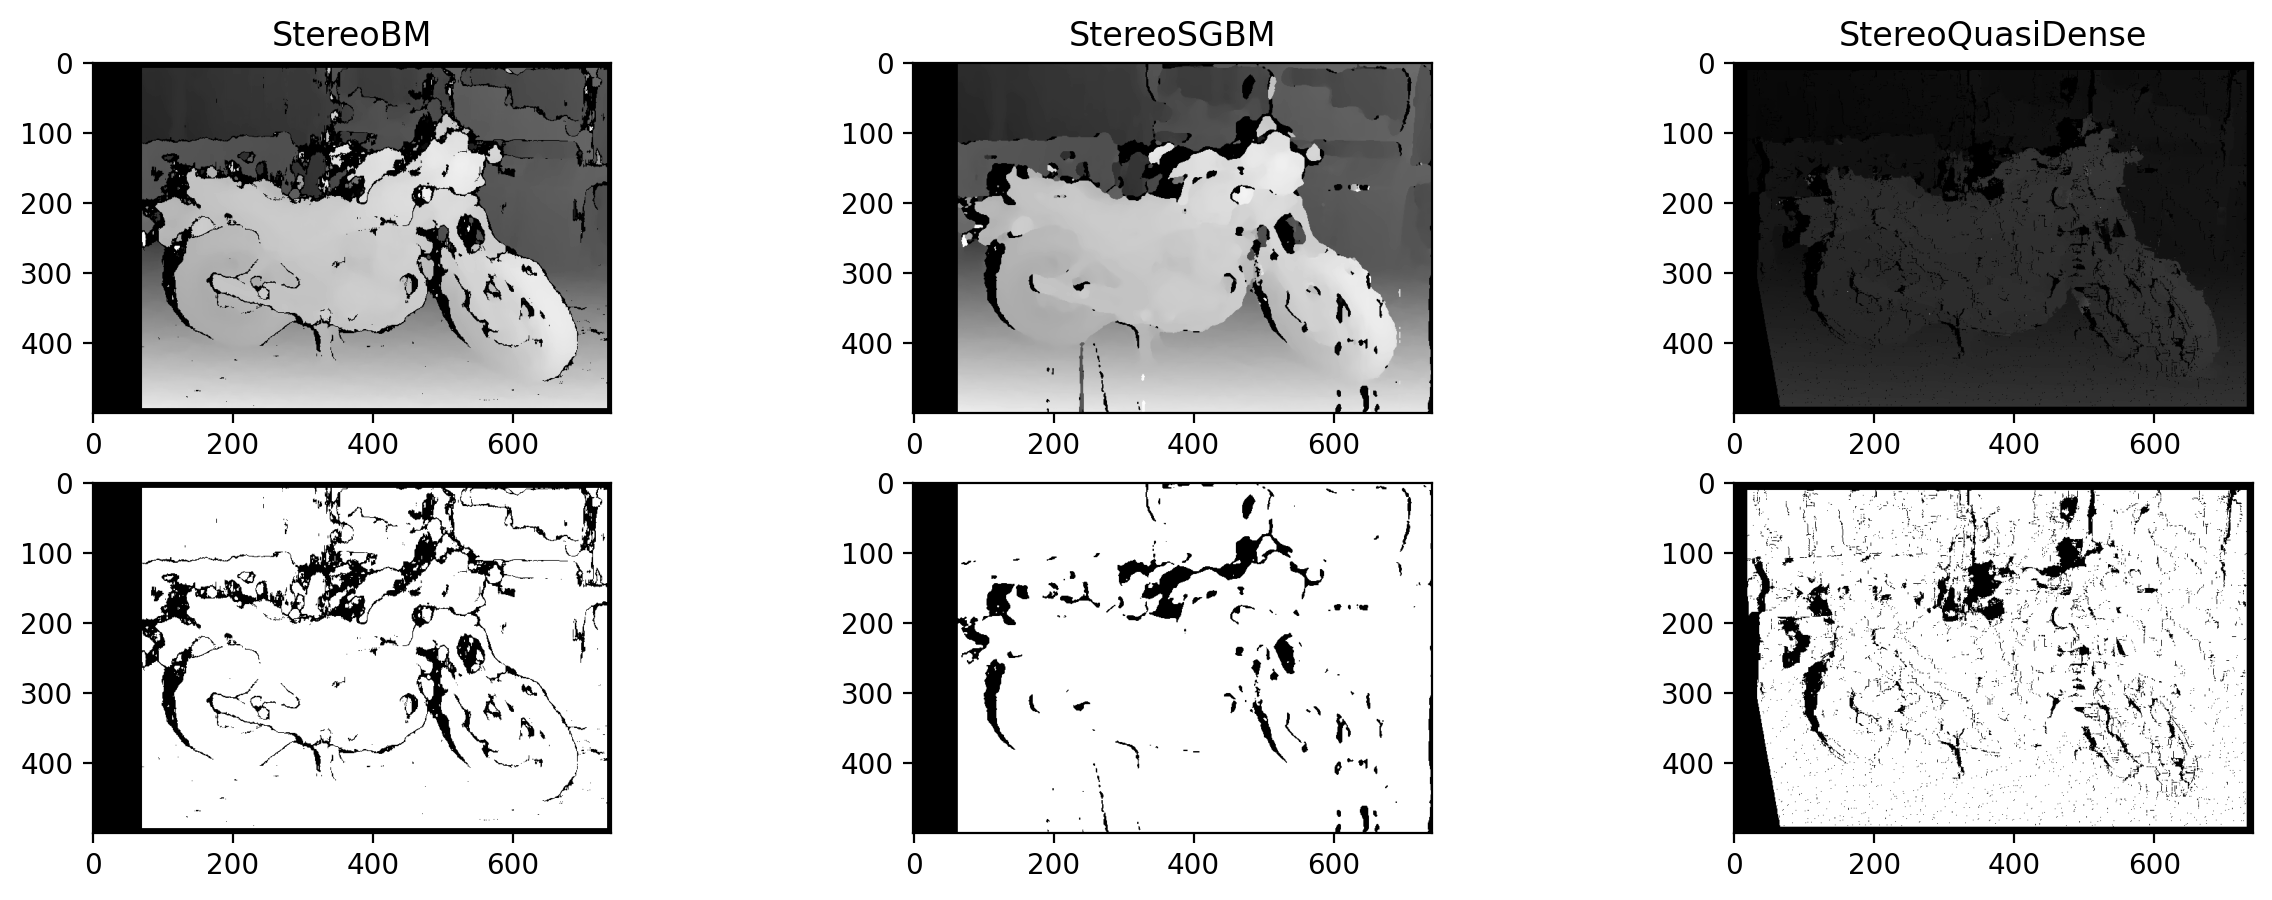

In [44]:
fig, ax = plt.subplots(2,3, figsize=(15,5))
ax[0,0].imshow(dispBM, cmap='gray')
ax[0,0].set_title('StereoBM')
ax[0,1].imshow(dispSGBM, cmap='gray')
ax[0,1].set_title('StereoSGBM')
ax[0,2].imshow(dispQD, cmap='gray')
ax[0,2].set_title('StereoQuasiDense')
ax[1,0].imshow(dispBM_mask, cmap='gray')
ax[1,1].imshow(dispSGBM_mask, cmap='gray')
ax[1,2].imshow(dispQD_mask, cmap='gray')
plt.show()

In [55]:
# from disparity map to depth map ( while applying mask )
f = 994.978
b = 0.193001
dispBM_masked = dispBM.copy()
dispBM_masked[~dispBM_mask] = np.nan
dispSGBM_masked = dispSGBM.copy()
dispSGBM_masked[~dispSGBM_mask] = np.nan
dispQD_masked = dispQD.copy()
dispQD_masked[~dispQD_mask] =  np.nan

dispBM_z = f*b/dispBM_masked
dispSGBM_z = f*b/dispSGBM_masked
dispQD_z = f*b/dispQD_masked

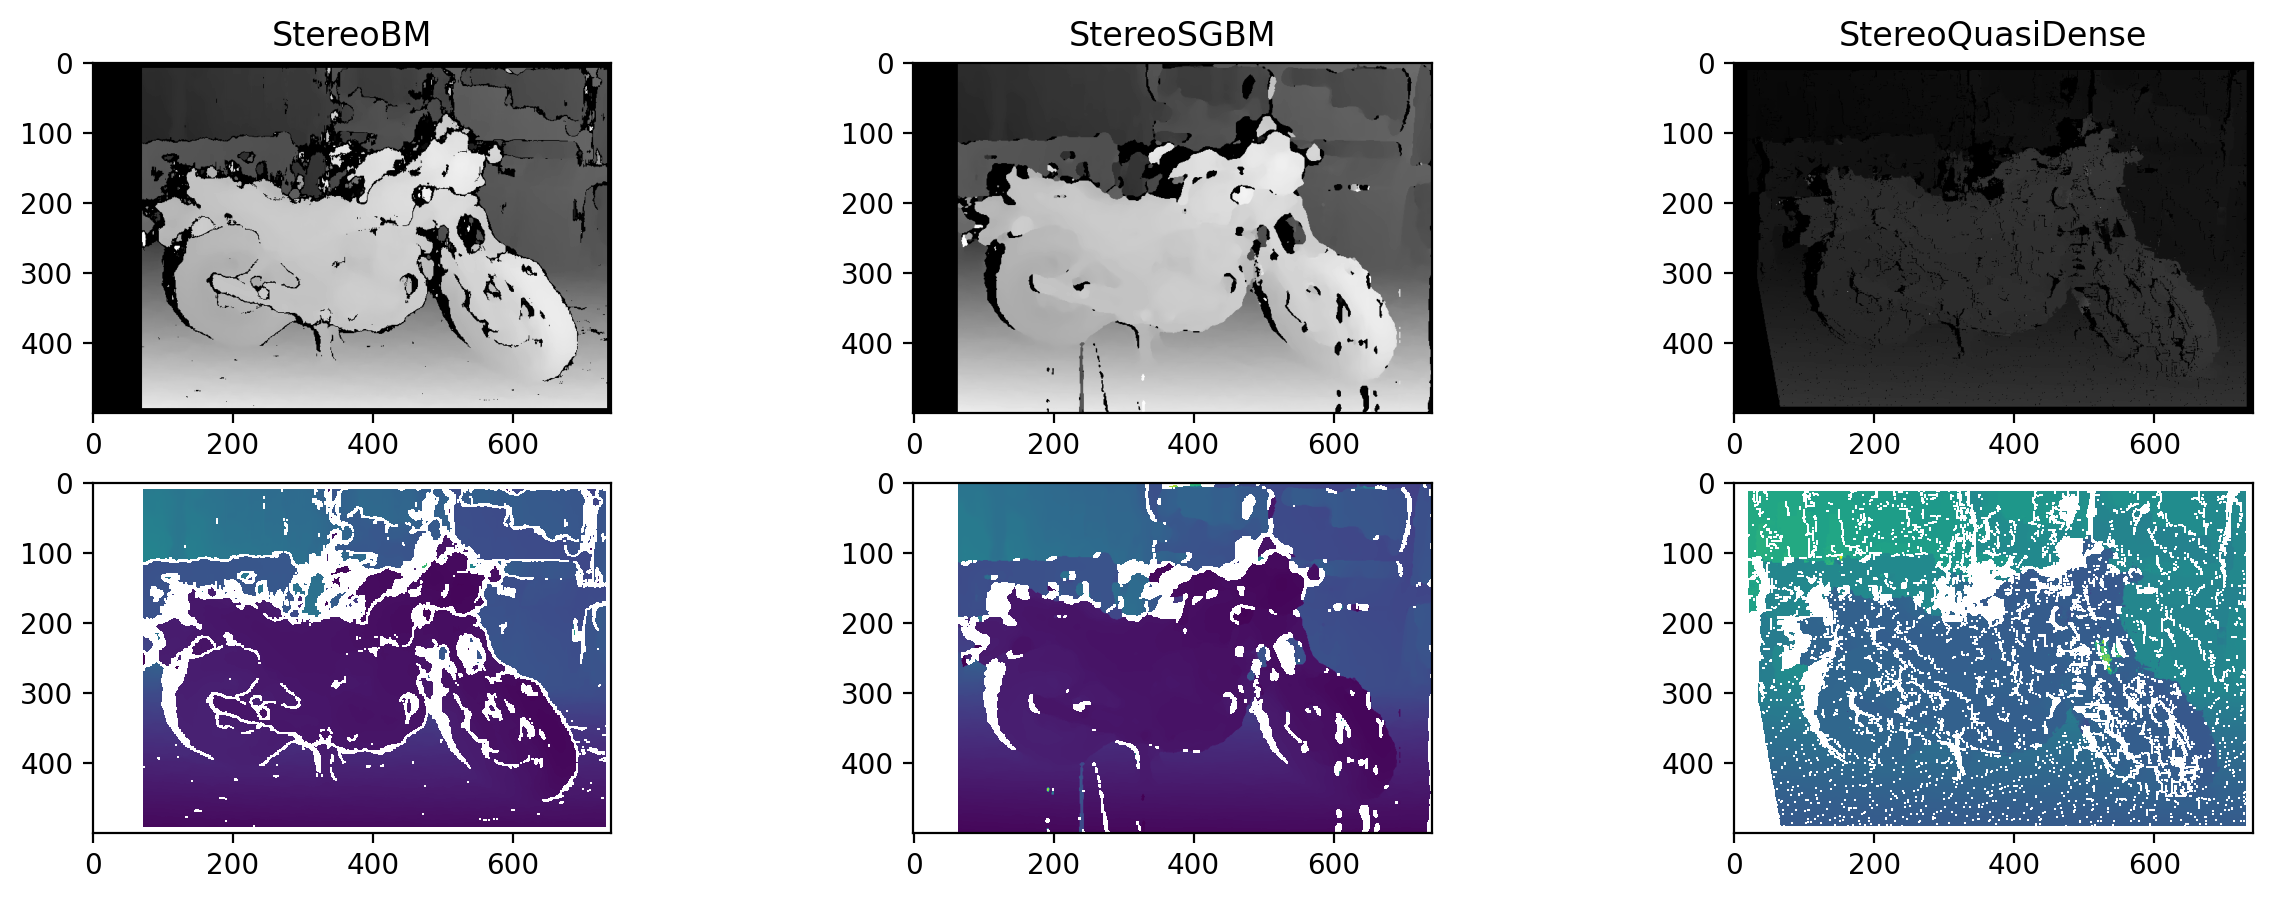

In [56]:
fig, ax = plt.subplots(2,3, figsize=(15,5))
ax[0,0].imshow(dispBM, cmap='gray')
ax[0,0].set_title('StereoBM')
ax[0,1].imshow(dispSGBM, cmap='gray')
ax[0,1].set_title('StereoSGBM')
ax[0,2].imshow(dispQD, cmap='gray')
ax[0,2].set_title('StereoQuasiDense')
ax[1,0].imshow(np.log(dispBM_z))
ax[1,1].imshow(np.log(dispSGBM_z))
ax[1,2].imshow(np.log(dispQD_z))
plt.show()

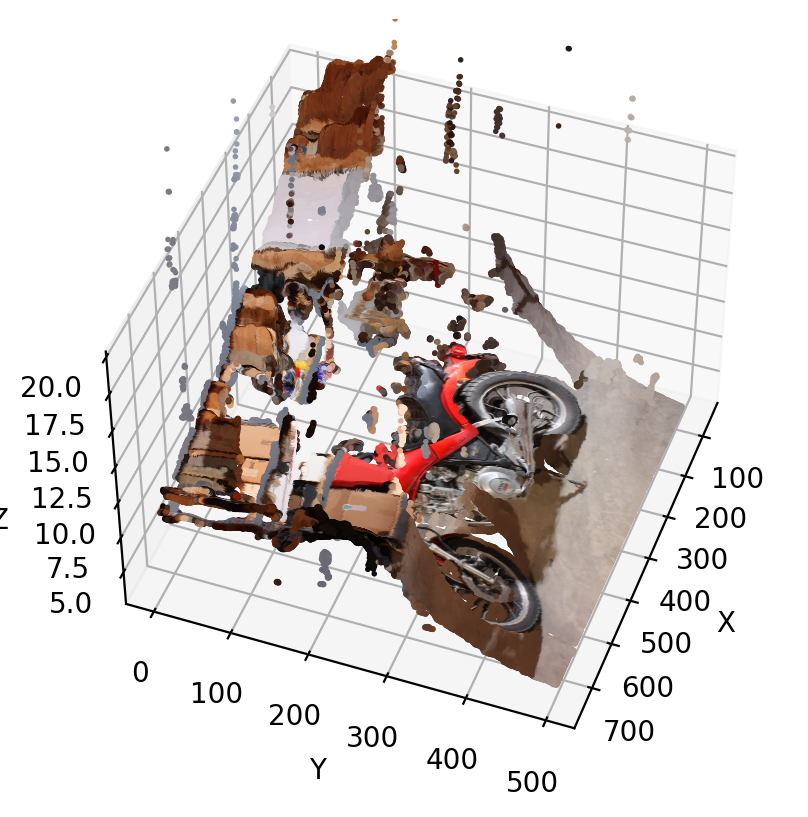

In [57]:
xx, yy = np.meshgrid(np.arange(Ig.shape[1]), np.arange(Ig.shape[0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx[dispSGBM_mask].flatten(), yy[dispSGBM_mask].flatten(),dispSGBM_z[dispSGBM_mask].flatten(),s=1, c=Ig[dispSGBM_mask].reshape((-1,3))/255.,depthshade=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim([3.,20.]) # limite raisonnable de z pour la scene plt.show()

# set the camera position to look at the y/z axis
ax.view_init(elev=45, azim=20)

In [6]:
from numba import njit

@njit
def SAD(block1, block2):
    return np.sum(np.abs(block1 - block2))

@njit
def SAD_all(ref_block, comp_blocks):
    return np.array([SAD(ref_block, comp_block) for comp_block in comp_blocks])

# implementation of block matching disparity computing
def disp(img1: np.ndarray, img2: np.ndarray, maxdisp: int, block_size: int = 5) -> np.ndarray:
    """
    Compute the disparity map between two images
    :param img1: left image in grayscale
    :param img2: right image in grayscale
    :param maxdisp: maximum disparity
    :param block_size: size of the block, defaults to 5
    :return: disparity map
    """
    disp_map = np.zeros_like(img1)
    for j in range(img1.shape[0]): # for each line
        for i in range(img1.shape[1]-maxdisp): # for each block in the line
            ref_block = img1[j:j+block_size, maxdisp+i:maxdisp+i+block_size]
            comp_blocks = [img2[j:j+block_size, maxdisp+i-k:maxdisp+i-k+block_size] for k in range(maxdisp)]
            # remove bad shape
            comp_blocks = np.array([comp_block for comp_block in comp_blocks if comp_block.shape == ref_block.shape])
            # compute the SAD between the reference block and the blocks in the right image
            ssd = SAD_all(ref_block, comp_blocks)
            # find the index of the minimum SAD
            min_ssd = np.argmin(ssd)
            # compute the disparity
            disp_map[j:j+block_size, maxdisp+i:maxdisp+i+block_size] = min_ssd
    return disp_map

def disp_inv(img1: np.ndarray, img2: np.ndarray, maxdisp: int, block_size: int = 5) -> np.ndarray:
    """
    Compute the disparity map between two images, from right to left
    :param img1: left image in grayscale
    :param img2: right image in grayscale
    :param maxdisp: maximum disparity
    :param block_size: size of the block, defaults to 5
    :return: disparity map
    """
    disp_map = np.zeros_like(img2)
    for j in range(img2.shape[0]): # for each line
        for i in range(img2.shape[1]-maxdisp): # for each block in the line
            ref_block = img2[j:j+block_size, i:i+block_size]
            comp_blocks = [img1[j:j+block_size, i+k:i+k+block_size] for k in range(maxdisp)]
            # remove bad shape
            comp_blocks = np.array([comp_block for comp_block in comp_blocks if comp_block.shape == ref_block.shape])
            # compute the SAD between the reference block and the blocks in the right image
            ssd = SAD_all(ref_block, comp_blocks)
            # find the index of the minimum SSD
            min_ssd = np.argmin(ssd)
            # compute the disparity
            disp_map[j:j+block_size, i:i+block_size] = min_ssd
    return disp_map

In [5]:
import time

my_disp_map = disp(Iggray, Idgray, 60)
plt.imshow(my_disp_map, cmap='gray')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'unsafe_empty_inferred' is not defined

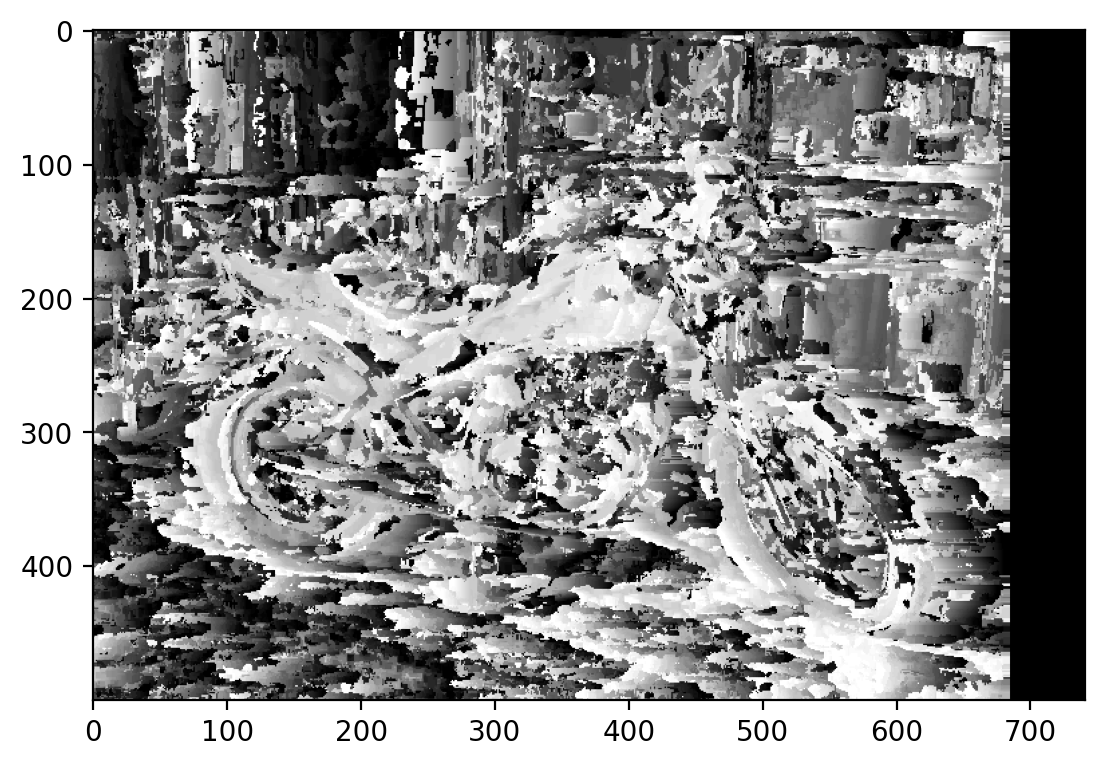

In [22]:
my_inv_dist_map = disp_inv(Iggray, Idgray, 60)
plt.imshow(my_inv_dist_map, cmap='gray')

In [55]:
# mode filter to smooth the disparity map
def mode_filter(disp_map: np.ndarray, filter_size=5):
    """
    Apply a mode filter to the disparity map
    :param disp_map: disparity map
    :param filter_size: size of the filter, defaults to 5
    :return: filtered disparity map
    """
    disp_map_filtered = np.zeros_like(disp_map)
    for j in range(disp_map.shape[0]-filter_size):
        for i in range(disp_map.shape[1]-filter_size):
            # get the values in the filter
            values = disp_map[j:j+filter_size, i:i+filter_size]
            # compute the mode
            mode = np.bincount(values.flatten().astype(int)).argmax()
            # assign the mode to the center of the filter
            disp_map_filtered[j+filter_size//2, i+filter_size//2] = mode
    return disp_map_filtered

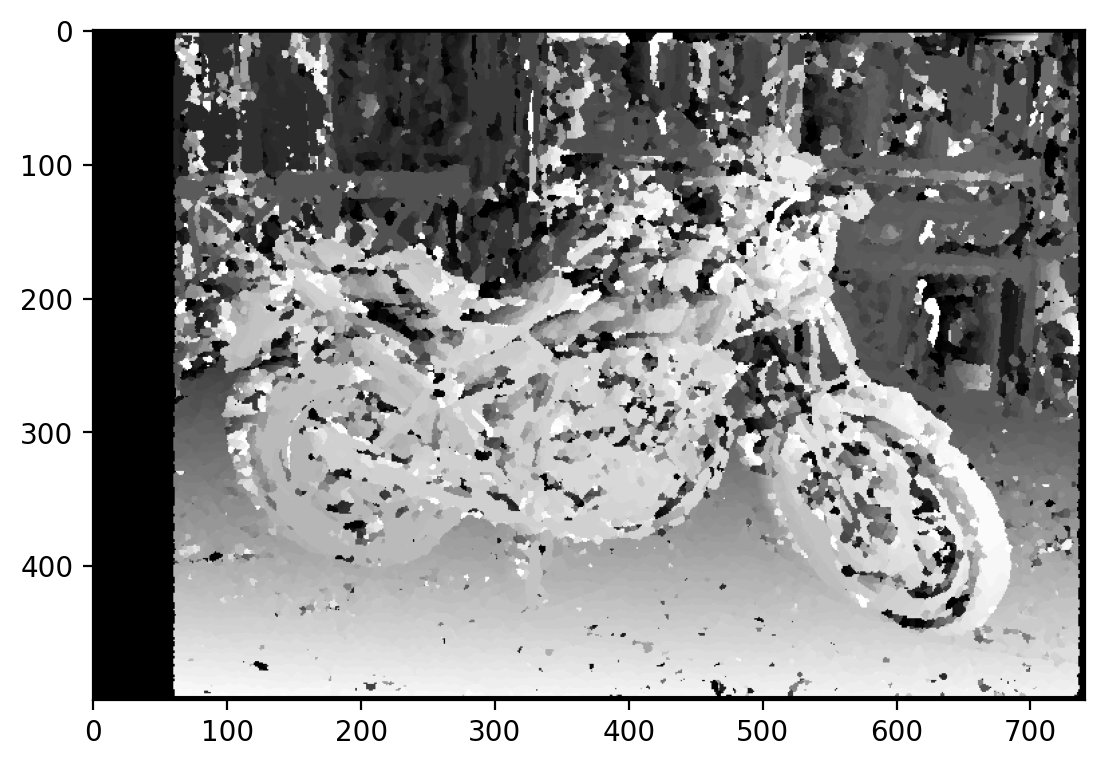

In [56]:
my_disp_map_filtered = mode_filter(my_disp_map)
plt.imshow(my_disp_map_filtered, cmap='gray')

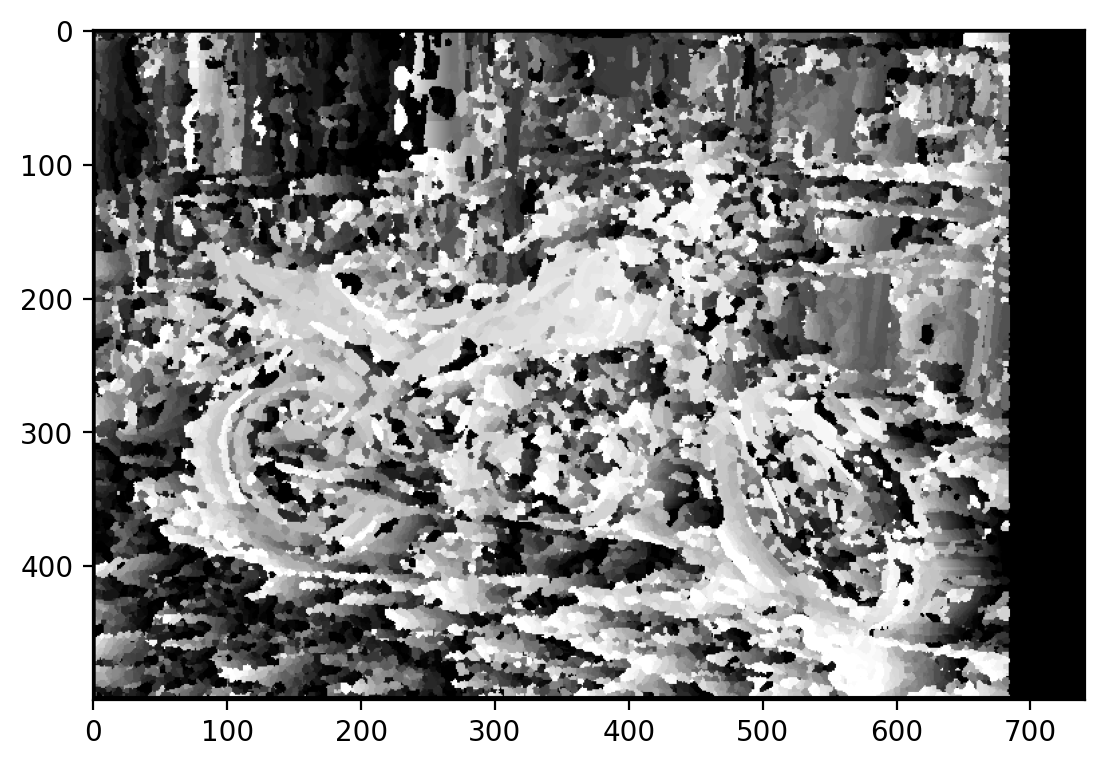

In [25]:
my_inv_disp_map_filtered = mode_filter(my_inv_dist_map)
plt.imshow(my_inv_disp_map_filtered, cmap="gray")

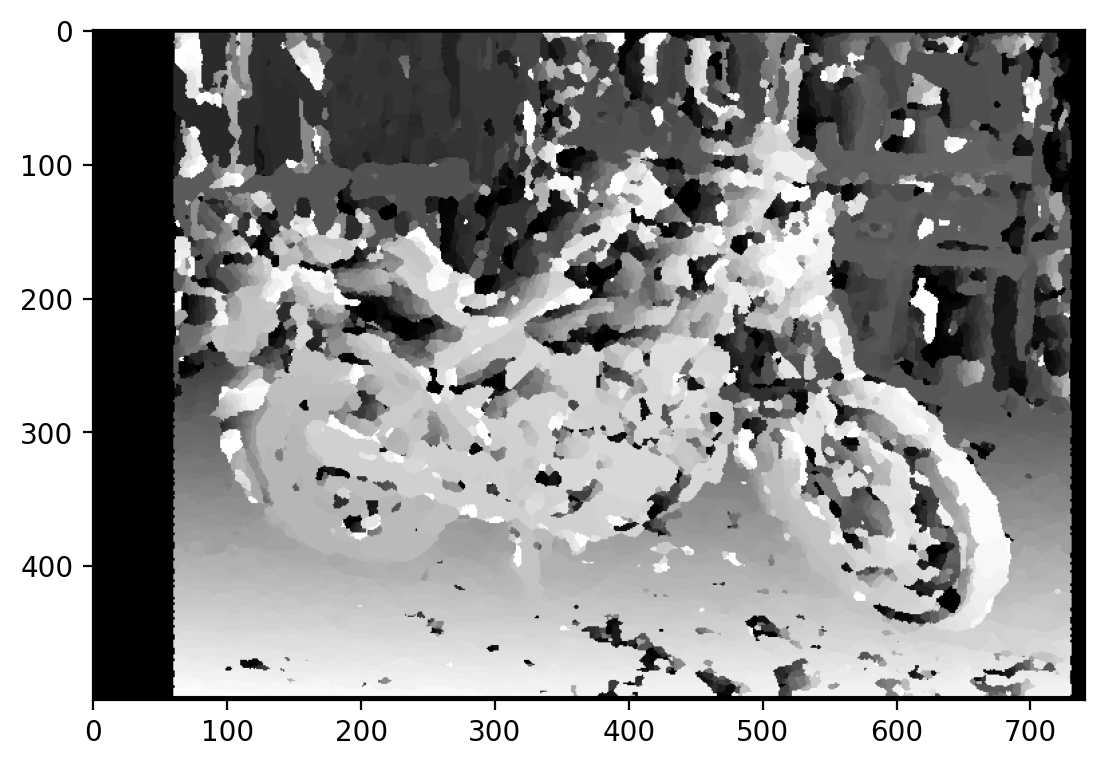

In [28]:
# test with block_size = {3, 5, 11, 21}
block_size = 3
my_disp_map_3 = disp(Iggray, Idgray, 60, block_size)
my_disp_map_3_filtered = mode_filter(my_disp_map, filter_size=8)
plt.imshow(my_disp_map_filtered, cmap='gray')

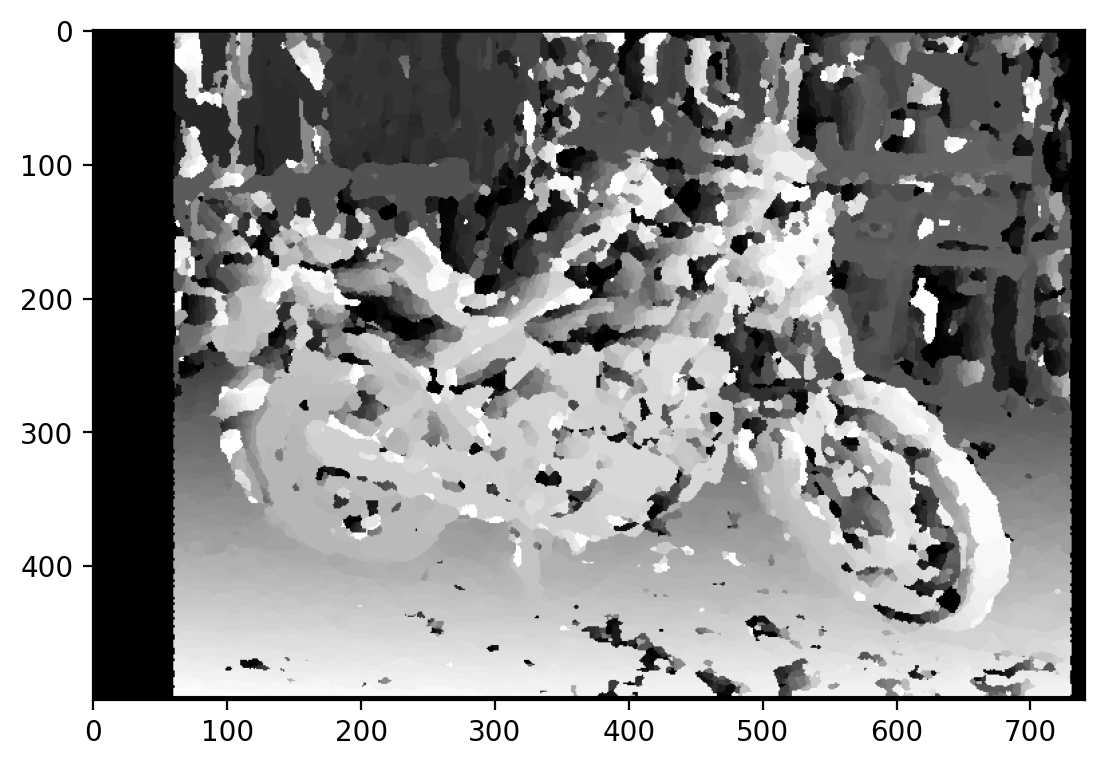

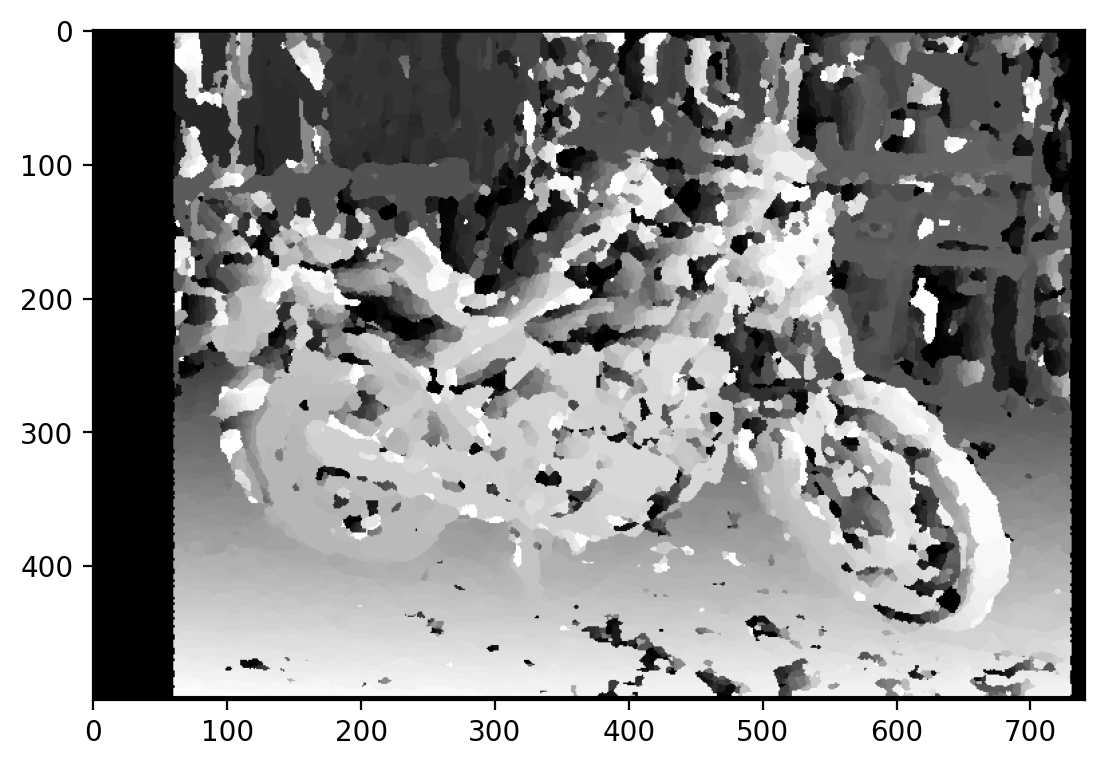

In [30]:
block_size = 11
my_disp_map_11 = disp(Iggray, Idgray, 60, block_size)
my_disp_map_11_filtered = mode_filter(my_disp_map, filter_size=5)
plt.imshow(my_disp_map_filtered, cmap='gray')

In [10]:
block_size = 21
my_disp_map_21 = disp(Iggray, Idgray, 60, block_size)
my_disp_map_21_filtered = mode_filter(my_disp_map, filter_size=5)
plt.imshow(my_disp_map_filtered, cmap='gray')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'unsafe_empty_inferred' is not defined

# Expérimentations avec un meilleur filtrage

on se base sur [10.1109/TPAMI.2006.70](https://sci-hub.se/10.1109/TPAMI.2006.70) pour définir une meilleure façon de filtrer la carte de disparité.

In [7]:
from skimage import color
from typing import Tuple

@njit
def delta_c(p: np.ndarray,q: np.ndarray) -> float:
    """
    Computes the color distance between two pixels as the Euclidean distance between the two colors in the L*a*b* color space
    :param p: first pixel in LAB
    :param q: second pixel in LAB
    :return: color distance
    """
    # compute the Euclidean distance
    return np.sqrt(np.sum((p-q)**2))

@njit
def delta_g(p: Tuple[int, int], q:Tuple[int,int]) -> float:
    """
    Computes the Euclidean distance between two pixels positions
    :param p: first pixel position
    :param q: second pixel position
    :return: distance
    """
    return np.sqrt(np.sum((np.array(p)-np.array(q))**2))

@njit
def w(i: np.ndarray, p: Tuple[int, int], q: Tuple[int, int], gamma_c: float = 5, gamma_p: float = 17.5) -> float:
    """
    Computes the weight between two pixels as defined by Yoon and Kweon (2006) eq.6
    :param i: image in LAB
    :param p: first pixel position
    :param q: second pixel position
    :param gamma_c: color variance, defaults to 10
    :param gamma_p: position variance, defaults to 2
    :return: weight
    """
    return np.exp(-delta_c(i[p], i[q])**2/gamma_c**2 - delta_g(p, q)**2/gamma_p**2)

@njit
def e(p: np.ndarray, q: np.ndarray, t: float = 40.0) -> float:
    """
    Computes pixel-based raw matching cost by using the colors of p and q, as defined by Yoon and Kweon (2006) eq.8 (truncated SAD)
    :param p: first pixel
    :param q: second pixel
    :param t: truncation parameter
    :return: matching cost
    """
    return min(np.sum(np.abs(p-q)), t)

@njit
def dissimilarity(i_ref: np.ndarray, i_tgt: np.ndarray, i_ref_lab: np.ndarray, i_tgt_lab: np.ndarray, p: Tuple[int, int], d: int, win_size: int = 35) -> float:
    """
    Computes the dissimilarity between two pixels as defined by Yoon and Kweon (2006) eq.7
    :param i_ref: reference image
    :param i_tgt: target image
    :param i_ref_lab: reference image in LAB
    :param i_tgt_lab: target image in LAB
    :param p: pixel position
    :param d: first estimation of disparity
    :param t: truncation parameter
    :param win_size: size of the window, defaults to 35
    :return: dissimilarity
    """
    total_num = 0
    total_deno = 0
    for dx in range(win_size):
        dx = dx - win_size//2
        for dy in range(win_size):
            dy = dy - win_size//2
            if p[0]+dy >= i_ref.shape[0] or p[1]+dx >= i_ref.shape[1] or p[0]+dy < 0 or p[1]+dx < 0:
                continue
            w_ref = w(i_ref_lab, p, (p[0]+dy,p[1]+dx))
            w_tgt = w(i_tgt_lab, (p[0], p[1]-d), (p[0]+dy, p[1]+dx-d))
            e_q = e(i_ref[p[0]+dy, p[1]+dx], i_tgt[p[0]+dy, p[1]+dx-d])
            total_num += w_ref*w_tgt*e_q
            total_deno += w_ref*w_tgt
    return total_num/total_deno

In [8]:
from tqdm.notebook import tqdm

def yoon_kweon_filter(i_ref: np.ndarray, i_tgt: np.ndarray, i_ref_lab: np.ndarray, i_tgt_lab: np.ndarray, init_dis: np.ndarray) -> np.ndarray:
    """
    Computes the disparity map by using the Yoon and Kweon (2006) algorithm
    :param i_ref: reference image
    :param i_tgt: target image
    :param i_ref_lab: reference image in LAB
    :param i_tgt_lab: target image in LAB
    :param init_dis: initial disparity map
    :return: disparity map
    """
    # get the shape of the image
    h, w = i_ref.shape[:2]

    # compute dissimilarity (E) map
    diss = np.zeros_like(init_dis)
    for x in tqdm(range(w)):
        for y in range(h):
            diss[y, x] = dissimilarity(i_ref, i_tgt, i_ref_lab, i_tgt_lab, (y, x), init_dis[y, x])


    # initialize the disparity map
    dis = np.zeros_like(init_dis)
    window_size = 5
    # for each pixel
    for x in tqdm(range(h)):
        for y in range(w):
            min_diss = np.inf
            for i in range(5):
                for j in range(5):
                    di = i - 2
                    dj = j - 2
                    if x+di < 0 or x+di >= h or y+dj < 0 or y+dj >= w:
                        continue
                    # fetch diss (E) from map
                    d = diss[x+di, y+dj]
                    if d < min_diss and init_dis[x+di, y+dj] != 0:
                        min_diss = d
                        dis[x, y] = init_dis[x+di, y+dj]
    return dis

In [9]:
# init disp is the pixel by pixel disparity map
my_disp_map = np.zeros(Ig.shape[:-1])
for x in tqdm(range(Ig.shape[1])):
    for y in range(Ig.shape[0]):
        min_disp = np.inf
        for d in range(60):
            diss = e(Ig[y, x], Id[y, x-d])
            if diss < min_disp:
                min_disp = diss
                my_disp_map[y, x] = d

  0%|          | 0/741 [00:00<?, ?it/s]

In [10]:
my_disp_map = my_disp_map.astype(np.uint8)

In [11]:
i_ref_lab = color.rgb2lab(Ig)
i_tgt_lab = color.rgb2lab(Id)
filtered_disp_map = yoon_kweon_filter(Ig, Id, i_ref_lab, i_tgt_lab, my_disp_map)

  0%|          | 0/741 [00:00<?, ?it/s]

KeyboardInterrupt: 

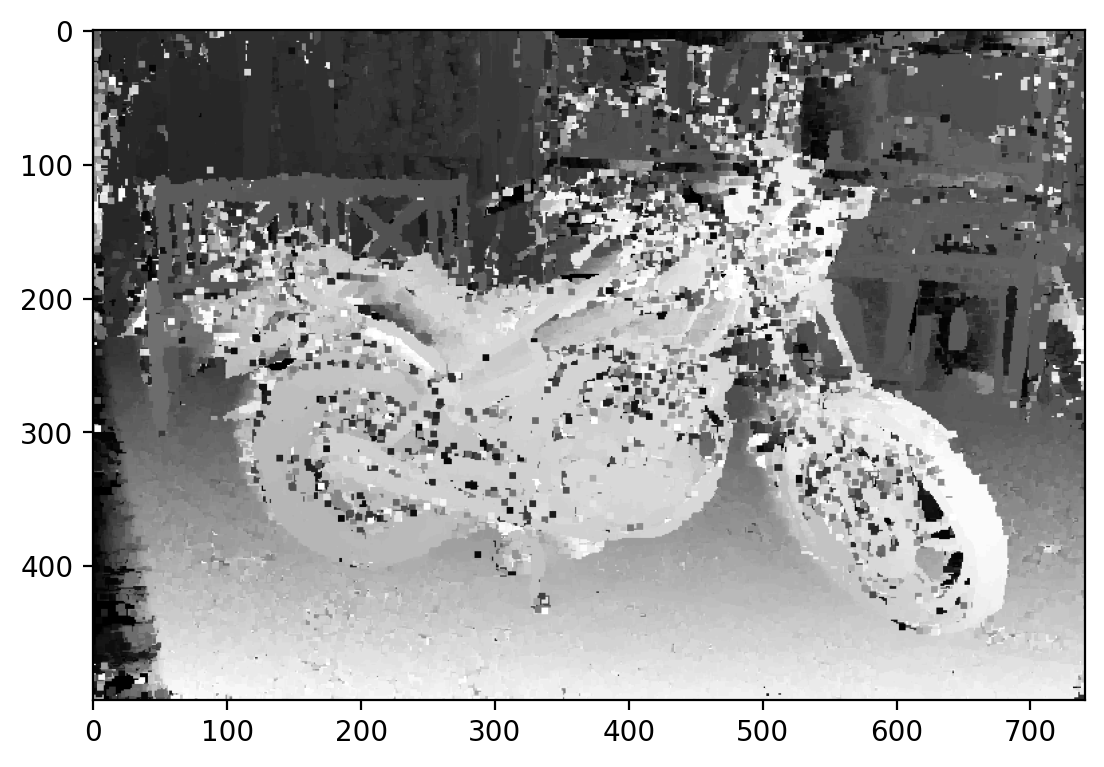

In [30]:
plt.imshow(filtered_disp_map, cmap='gray')

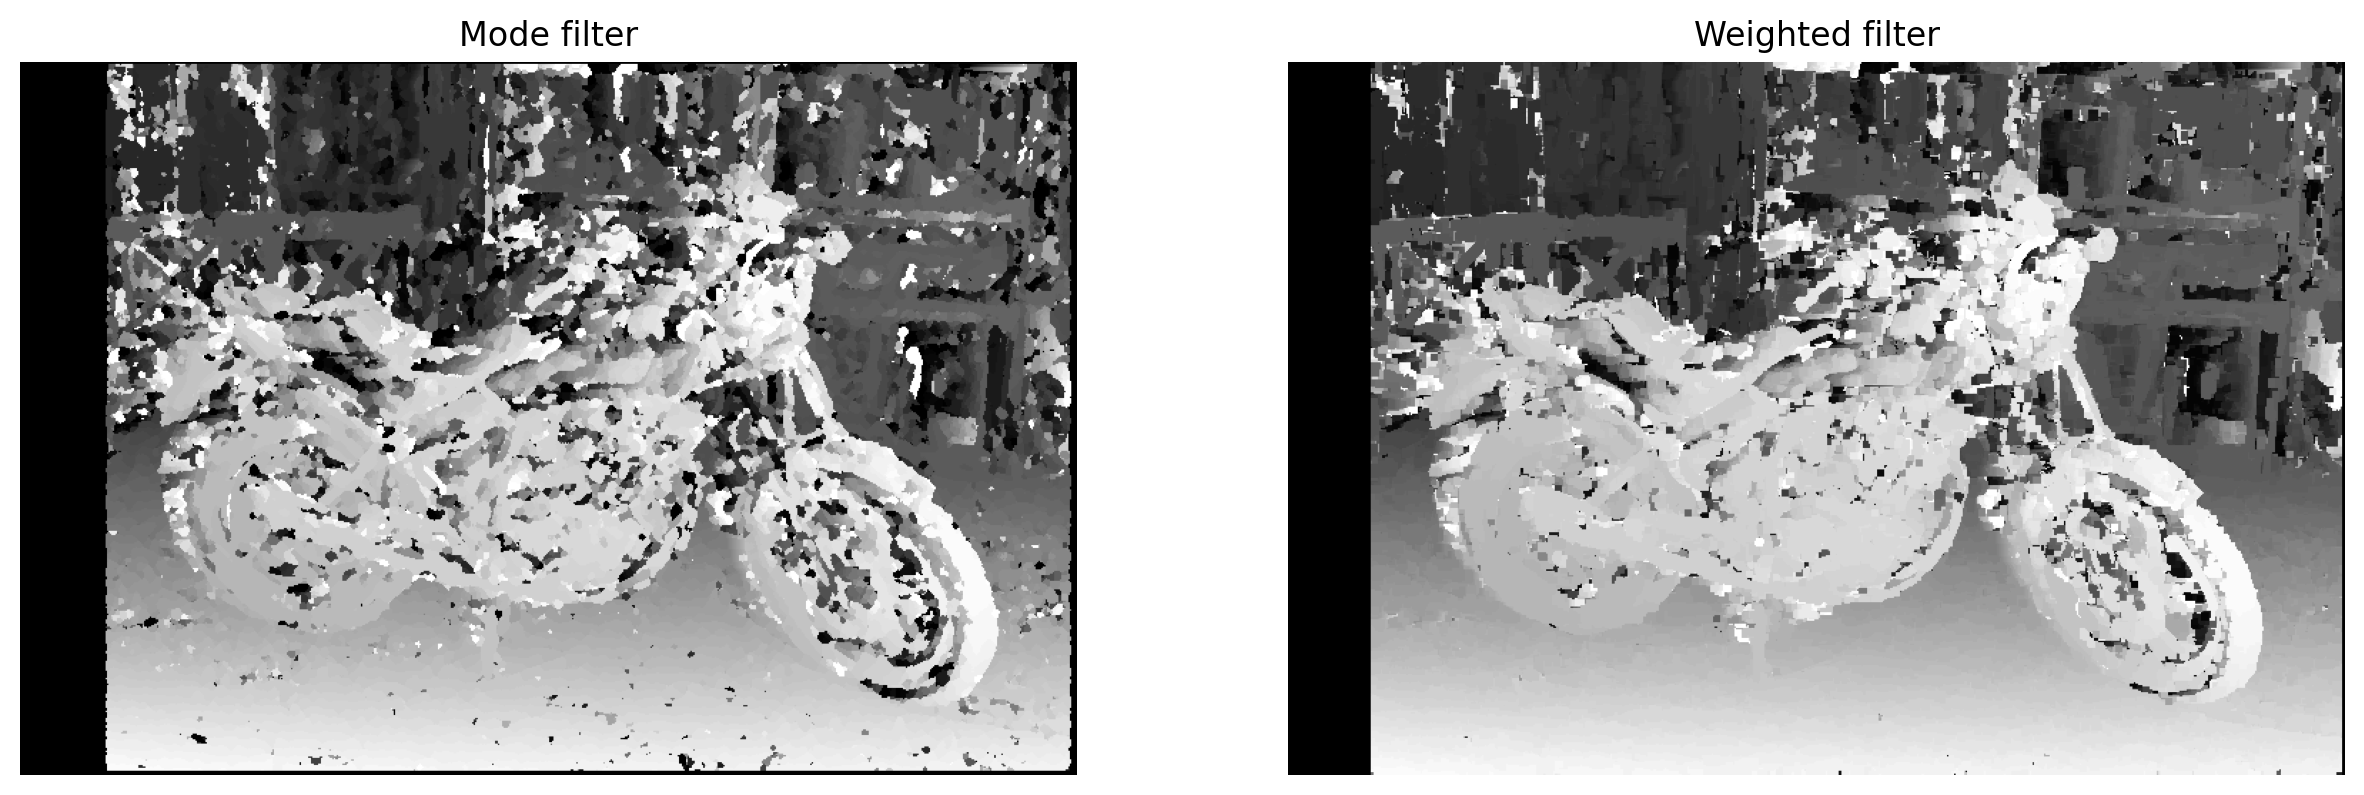

In [57]:
# compare the mode filter with the weighted one
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(my_disp_map_filtered, cmap='gray')
plt.title('Mode filter')
plt.subplot(1, 2, 2)
plt.imshow(filtered_disp_map, cmap='gray')
plt.title('Weighted filter')
# remove axes
for ax in plt.gcf().axes:
    ax.axis('off')
plt.show()

On remarque que le filtrage est meilleur, mais il prend ~100s par image (contre 0.5s pour le mode filter)

Essayons maintenant cet algorithme en tant que matcheur de blocs directement, et non en filtrage.

In [9]:
@njit
def yoon_kweon_matcher(i_ref: np.ndarray, i_tgt: np.ndarray, i_ref_lab: np.ndarray, i_tgt_lab: np.ndarray, max_diss: int) -> np.ndarray:
    """
    Computes the disparity map by using the Yoon and Kweon (2006) algorithm
    :param i_ref: reference image
    :param i_tgt: target image
    :param i_ref_lab: reference image in LAB
    :param i_tgt_lab: target image in LAB
    :param init_dis: initial disparity map
    :return: disparity map
    """
    # get the shape of the image
    h, w = i_ref.shape[:2]

    print("starting computing")
    # compute dissimilarity (E) map
    diss = np.zeros_like(i_ref)
    for x in range(w):
        print("Computing dissimilarity for column ", x, "/", w)
        for y in range(h):
            best_matching_diss = np.inf
            for d in range(max_diss):
                curr_diss = dissimilarity(i_ref, i_tgt, i_ref_lab, i_tgt_lab, (y, x), d)
                if curr_diss < best_matching_diss:
                    best_matching_diss = curr_diss
                    diss[y, x] = d

    return diss

In [ ]:
my_disp_map = yoon_kweon_matcher(Ig, Id, i_ref_lab, i_tgt_lab, 50)

starting computing
Computing dissimilarity for column  0 / 741
Computing dissimilarity for column  1 / 741
Computing dissimilarity for column  2 / 741
Computing dissimilarity for column  3 / 741
Computing dissimilarity for column  4 / 741
Computing dissimilarity for column  5 / 741
Computing dissimilarity for column  6 / 741
Computing dissimilarity for column  7 / 741
Computing dissimilarity for column  8 / 741
Computing dissimilarity for column  9 / 741
Computing dissimilarity for column  10 / 741
Computing dissimilarity for column  11 / 741
Computing dissimilarity for column  12 / 741
Computing dissimilarity for column  13 / 741
Computing dissimilarity for column  14 / 741
Computing dissimilarity for column  15 / 741
Computing dissimilarity for column  16 / 741
Computing dissimilarity for column  17 / 741
Computing dissimilarity for column  18 / 741
Computing dissimilarity for column  19 / 741
Computing dissimilarity for column  20 / 741
Computing dissimilarity for column  21 / 741
C